# Практическое задание

## Вычитание фона

### О задании

В данном задании вам предлагается самостоятельно реализовать алгоритм вычитания фона ViBe. Протестировать этот алгорит на датасете ChangeDetection 2014 года, а также сравнить качество его работы с алгоритмом, основанным на смеси гауссиан. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. Необходимо установить следующие пакеты: `numpy`, `skimage`, `opencv`. 

In [1]:
#!pip3 install numpy scikit-image opencv-python

    100% |████████████████████████████████| 39.7MB 276kB/s ta 0:00:01
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


##  Часть 1

В этой части задания вам предстоит реализовать алгоритм вычитания фона *ViBe* и протестировать его качество работы на датасете *Change Detection 2014*.


**1. (3 балла)**

Прочитайте статью, выданную вам совместно с ноутбуком, описывающую алгоритм *ViBe* и реализуйте следующие его ключевые особенности: 
1. *Цветовая модель пикселей.* Для каждого пикселя хранится набор $\{p_1, ..., p_N\}$ - значений цвета данного пикселя в предыдущие моменты времени. 
2. *Классификация пикселей.* Для каждого нового кадра пиксель считается пикселем фона, если среди значений  $\{p_1, ..., p_N\}$ его цветовой модели содержится не менее K значений, расстояние до которых меньше радиуса R по евклидовой метрике.
3. *Обновления цветовой модели.* Если пиксель был классифицирован как пиксель фона, его цветовая модель обновляется следущий образом: случайно выбранная точка цветовой модели данного пикселя заменяется на новое значения. 
4. *Модель инициализации.* Иницилизируйте цветовую модель для каждого пикселя значением цвета пикселя на первом кадре, а также значениями цвета случайно выбранных соседей(используйте 4'x или 8'ми-связную модель соседства);

Дополните реализуйте следущую модификацию, предложенную этими же авторами позднее:
* "Random time subsampling". Во многих практических ситуациях нет необходимости обновлять фоновую модель каждого пикселя для каждого нового кадра. Если сделать фоновое обновление менее частым, мы искусственно продлеваем средний срок службы фоновых образцов и таким образом боремся со случайными движениями возникающими в кадре. "Random time subsampling" заключается в том что бы не обновлять фоновую модель для каждого пикселя после каждого кадра. А для каждому пикселю сопоставить случаюную величину, которая будет отвечать за то, чтобы обновлять модель данного пикселя или нет, так чтобы обновление произодило в среднем раз в `subsampling_time` кадров (т.е обновлять фоновую модель каждого пикселя с вероятностью `1 / subsampling_time`).

*Замечание*:

Для реализации модели Vibe используйте предоставленный шаблон. Реализация алгоритма на питоне будет работать медленно, поэтому старайтесь выполнять как можно больше вычислений матрично.

In [57]:
import os
from IPython import display

import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from tqdm import tqdm, tqdm_notebook

from itertools import product
import pandas as pd

Exception ignored in: <bound method tqdm.__del__ of 52it [5:12:15,  5.36it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 889, in __del__
    self.close()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1095, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 441, in _decr_instances
    cls._instances.remove(instance)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x1218d0188; to 'tqdm' at 0x11a5d45f8>


In [10]:
class Vibe:
    def __init__(self, sample_amount, radius, K, subsampling_time):
        """
        'Visual Background Extractor' algorithm of background subtraction

        :param sample_amount: number of samples per pixel
        :param radius: radius of the sphere
        :param K: number of close samples for being part of background
        :param subsampling_time: amount of random subsampling
        """

        self.sample_amount = sample_amount
        self.radius = radius
        self.K = K
        self.subsampling_time = subsampling_time
        self.samples = None


    def initialize(self, image):
        """
        Initialize the model with frame of video sequence.

        :param image: initializining frame
        """
        height, width, colors = image.shape
        self.samples = np.zeros((height, width, self.sample_amount, colors))
        for h, w in product(range(height), range(width)):
                neighbors = np.random.choice([-1, 0, 1], size=(self.sample_amount, 2))
                for i, neighbor in enumerate(neighbors):
                    start = min(max(h + neighbor[0], 0), height - 1)
                    end = min(max(w + neighbor[1], 0), width - 1)
                    self.samples[h, w, i] = image[start, end]


    def apply(self, image):
        """
        Apply background subtraction algorithm to the next image,
        update internal parameters and return foreground mask.
        If model is not yet initialized, model must be initialized with this image.

        :param image: next image in video sequence
        :return: foreground mask
        """
        if self.samples is None:
            self.initialize(image)
            
        height, width, _ = image.shape
        
        samples_in_sphere = np.sqrt(((self.samples - image[:,:,np.newaxis,:]) ** 2).sum(axis=-1)) < self.radius
        first_mask = samples_in_sphere.sum(axis=(-1)) > self.K
        second_mask = np.random.binomial(1, 1 / self.subsampling_time, size=(height, width)) > 0
        final_mask = first_mask * second_mask
        objects_mask = np.logical_not(first_mask) * second_mask
        
        indexes = np.random.randint(0, self.sample_amount, (height, width))
        self.samples[final_mask][:,indexes[final_mask]] = image[final_mask]
        self.samples[objects_mask][:, -1] = image[objects_mask]
        self.samples[objects_mask][:, :-1] = self.samples[objects_mask][:, 1:]
        
        return np.logical_not(first_mask)

**2. (1 балл)**

Посмотрите как работает алгоритм на различных фрагментах видео из категориии Baseline датасета ChangeDetection2014, выданного вам совместно с ноутбуком. Поиграйтесь с параметрами и сделайте выводы.

Для визуализации покадрового применения алгоритма можете использовать код, написанный ниже.

*Замечание: *  
Полную версию датасета можно найти [здесь](http://changedetection.net/)

In [11]:
def image_generator(dirpath, first_frame=1, last_frame=None):
    """
    Generator of (frame_number, image, groundtruth) tuples.

    :param dirpath: Path to dir contained 'input' and 'groundtruth' subdirs
    :param first_frame: int, optional. Frame number from which the generator starts (inclusive)
    :param last_frame: int, optional. If provide, frame number  where the generator stops (inclusive)
    :return: (frame_number, image, groundtruth) tuples
    """

    input_format_name = 'input/in{:06d}.jpg'
    gt_format_name = 'groundtruth/gt{:06d}.png'

    numb = first_frame
    while (last_frame is None) or numb <= last_frame:
        input_path = os.path.join(dirpath, input_format_name.format(numb))
        gt_path = os.path.join(dirpath, gt_format_name.format(numb))

        if os.path.exists(input_path):
            input_image = skimage.io.imread(input_path)
            gt_image = skimage.io.imread(gt_path)
            if len(input_image.shape) == 2:
                input_image = input_image[..., np.newaxis]
            yield numb, input_image, gt_image
        else:
            break
        numb += 1
        
        
def apply_bg_substractor(bg_substractor, image_generator):
    """
    Apply background substruction algorithm for each frame of image_generator consistently

    :return: generator of (frame_number, frame, bg_substructor_mask, groundtruth) tuples
    """

    for numb, frame, gt in image_generator:
        mask = bg_substractor.apply(frame)
        yield numb, frame, mask, gt


def plot_bg_result(frame_number, frame, mask, gt, axs=None):
    """
    Draw frame, foreground mask, groundtruth mask images on axes.
    """
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(frame)
    axs[0].set_title("Frame: {}".format(frame_number))

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("BG result")

    axs[2].imshow(gt, cmap='gray')
    axs[2].set_title("Ground truth")

In [30]:
image_gen = image_generator(dirpath='dataset/baseline/highway/', first_frame=490, last_frame=530)
bg_substractor = Vibe(sample_amount=20, K=2, radius=30, subsampling_time=20)

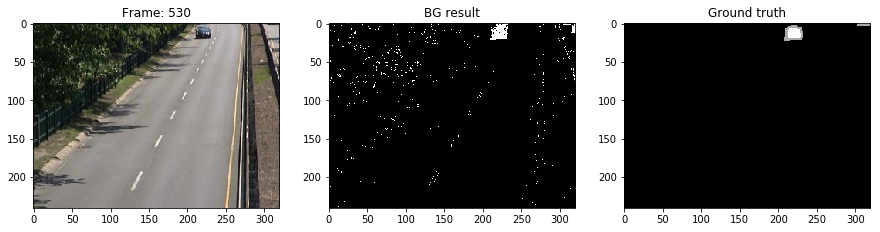



41it [00:25,  1.91it/s]



In [31]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**3. (1 балл)**

Визуально протестируйте алгоритм на видео из категории Baseline.  Покажите ключевые кадры и проанализируйте результаты.  Сделайте выводы о плюсах и минусах алгоритма. 

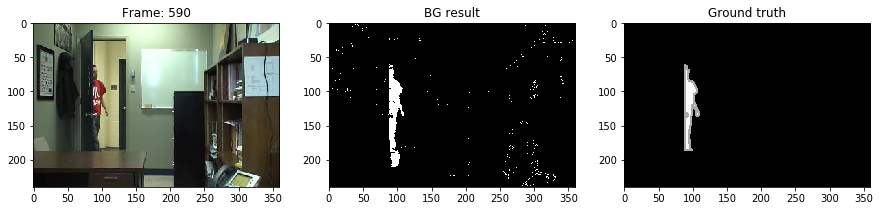



11it [00:11,  1.45it/s]



In [34]:
image_gen = image_generator(dirpath='dataset/baseline/office/', first_frame=580, last_frame=590)
bg_substractor = Vibe(sample_amount=20, K=2, radius=30, subsampling_time=20)

_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

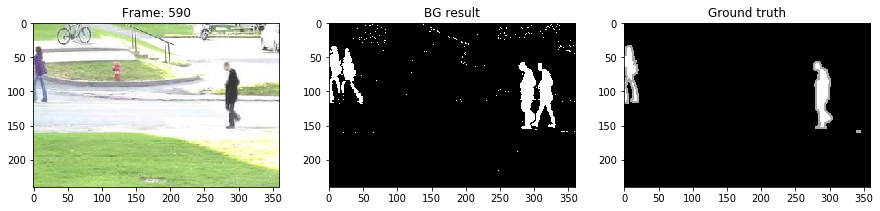



11it [00:11,  1.47it/s]



In [35]:
image_gen = image_generator(dirpath='dataset/baseline/pedestrians/', first_frame=580, last_frame=590)
bg_substractor = Vibe(sample_amount=20, K=2, radius=30, subsampling_time=20)

_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

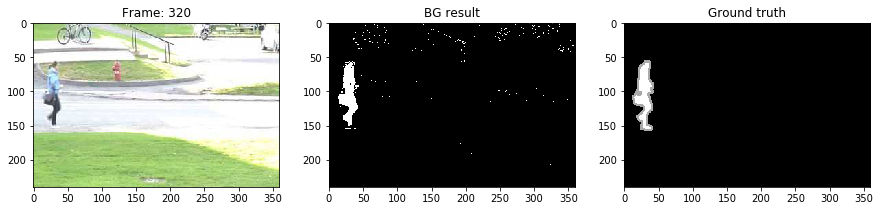




21it [00:16,  1.84it/s]




In [41]:
image_gen = image_generator(dirpath='dataset/baseline/pedestrians/', first_frame=300, last_frame=320)
bg_substractor = Vibe(sample_amount=20, K=2, radius=30, subsampling_time=20)

_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**Выводы:**
Если в начальный момент времени объекта нет, и он появляется позже, алгоритм хорошо его отслеживает. Если же в начальный момент объект уже есть, то алгоритму понадобится несколько первых итераций, чтобы отделить его от фона. Также, в таком случае после движения объекта, фон, который изначально был скрыт, может быть определен как объект. Кроме того, есть маленькая доля точек на фоне, которые определяются как объекты. 

## Часть 2

В этой части задания вам необходимо реализовать метрики оценки качества вычитания фона, протестировать реализованый вами алгоритм Vibe на категории Baseline датасета ChangeDetection2014.


**4. (0.5 балла)**

Реализуйте следущие метрики:
\begin{equation*}
\begin{array}{l}
Precision = \frac{TP}{TP + FP} \\
Recall = \frac{TP}{TP + FN} \\
F_1{\text -}score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{array}
\end{equation*}

In [42]:
def precision(confusion_matrix):
    """
    Compute the precision

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    tn, fp, fn, tp = confusion_matrix
    return tp / (tp + fp)


def recall(confusion_matrix):
    """
    Compute the recall

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    tn, fp, fn, tp = confusion_matrix
    return tp / (tp + fn)


def f1_score(confusion_matrix):
    """
    Compute the f1_score

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    curr_precision = precision(confusion_matrix)
    curr_recall = recall(confusion_matrix)
    return 2 * curr_precision * curr_recall / (curr_precision + curr_recall)

**5. (2 балла)**

Посчитайте значение метрик качества $precision$, $recall$, $f_1{\text -}score$ для всех видео из категории Baseline. Также посчитайте среднее значение этих метрик по категории. Вам необходимо достичь среднего значения $f_1{\text -}score$ более 0.8 для категории Baseline.

*Замечание 1:*  
$TP$, $FP$, $FN$, $TP$ надо аккумулировать для всего видео, после чего надо вычислить значение метрик для каждого видео по описанным выше формулам и усреднить по всем видео из категории.

*Замечание 2:*  
В разметке встречаются следующие метки:
* 0 : Static
* 50 : Hard shadow
* 85 : Outside region of interest
* 170 : Unknown motion (usually around moving objects, due to semi-transparency and motion blur)
* 255 : Motion

При подсчет метрик качества вам необходимо учитывать только метки: 0 и 50 - это пиксели фона, и 255 - это пиксели переднего плана. Пиксели, содержащие метки 85 и 170 надо не учитывать при подсчете метрик качества.

In [48]:
a += [1, 2, 3]

In [51]:
a

array([0, 0, 0])

In [50]:
a = np.array([0] * 3)

In [45]:
np.count_nonzero

In [112]:
results = {}

for video in tqdm_notebook(['highway', 'office', 'pedestrians']):#, 'PETS2006']):
    image_gen = image_generator(dirpath='dataset/baseline/{}/'.format(video))
    bg_substractor = Vibe(sample_amount=20, K=2, radius=30, subsampling_time=20)
    confusion_matrix = np.array([0] * 4)
    
    for numb, frame, mask, gt in tqdm_notebook(apply_bg_substractor(bg_substractor, image_gen)):
        positive_add = np.count_nonzero(np.logical_and(gt == 255, mask))
        negative_add = np.count_nonzero(np.logical_and(np.logical_or(gt == 0, gt == 50), np.logical_not(mask)))
        confusion_matrix += [negative_add, np.count_nonzero(mask) - positive_add, 
                        np.count_nonzero(np.logical_not(mask)) - negative_add, positive_add]
    results[video] = [precision(confusion_matrix), recall(confusion_matrix), f1_score(confusion_matrix)]   

In [113]:
results['mean'] = [np.mean([metrics[i] for metrics in results.values()]) for i in range(3)]

In [68]:
pd.DataFrame(results, index=['precision', 'recall', 'f1'])

,highway,office,pedestrians,PETS2006,mean
precision,0.849916,0.669445,0.929892,0.919987,0.842310
recall,0.294380,0.347748,0.282120,0.245110,0.292339
f1,0.437296,0.457727,0.432902,0.387088,0.428753


## Часть 3

В этой части задания вам предстоит протестировать алгоритм, основанный на смеси гауссиан из библиотеки `opencv`. Сравнить работу этого алгоритма с алгоритмом Vibe, а также посмотреть как ведут себя алгоритмы при добавление шума различной степени на изображение.


**6. (0.5 балл)**

Посмотрите как ведет себя алгоритм `MOG2` из библиотеки `opencv`. Аналогично как из с алгоритмом Vibe провизиализируйте покадровую работу алгоритма на какой-нибудь части видео и визуально оцените качество работы взависимости от параметров `history` и `varThreshhold`, параметр `detectShadows` установите равным False. Какие выводы вы можете сделать?

In [69]:
from cv2 import createBackgroundSubtractorMOG2

mog2 =  createBackgroundSubtractorMOG2(detectShadows=False, history=60, varThreshold=20)
image_gen = image_generator(dirpath='dataset/baseline/pedestrians/', first_frame=300, last_frame=350)

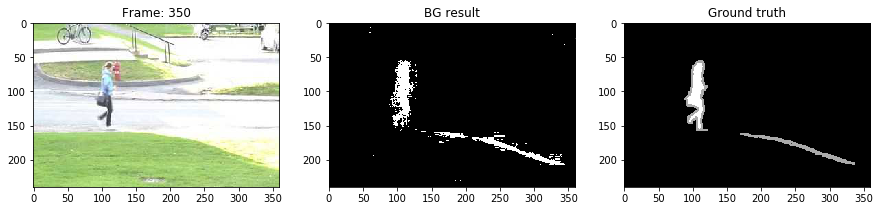


51it [00:17,  2.65it/s]


In [70]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

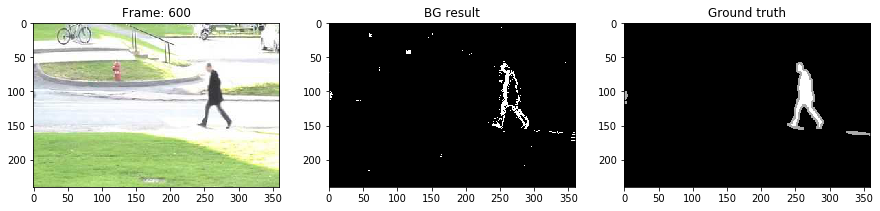

21it [00:07,  2.76it/s]


In [77]:
mog2 =  createBackgroundSubtractorMOG2(detectShadows=False, history=100, varThreshold=20)
image_gen = image_generator(dirpath='dataset/baseline/pedestrians/', first_frame=580, last_frame=600)

_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

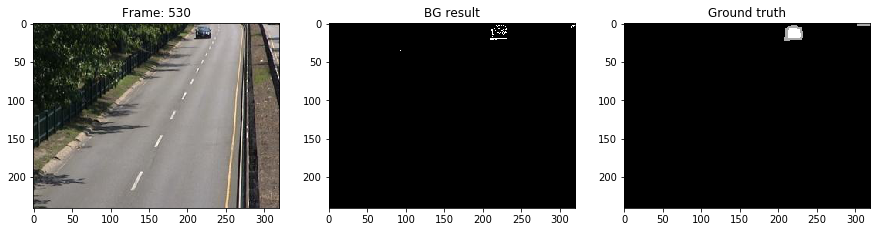

41it [00:14,  2.67it/s]


In [79]:
mog2 =  createBackgroundSubtractorMOG2(detectShadows=False, history=50, varThreshold=100)
image_gen = image_generator(dirpath='dataset/baseline/highway/', first_frame=490, last_frame=530)

_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**Выводы:**

При большом трешхолде алгоритму сложно выделить объект целиком, при маленьком -- появляется больше шумов.
На проверенных примерах влияние истории заметить было сложно, но более длинная история позволяет четче уловить, что на картине -- фон, а что -- объект, который не движется некоторое время, так как этот параметр отвечает за количество проследних кадров, используемых для построения модели фона

**7. (1 балл)**

Выберите один кадр из набора ключевых кадров, отобранных ключевых кадрах в пункте 3 и добавляйте к
нему попиксельно независимый гауссовский шум. Проанализируйте результаты вычитания фона обоими методами для шума различной интенсивности. Подберите параметры алгоритмов для работы с зашумленными изображениями.  Визуализируйте результаты работы обоих алгоритмов а также вычислите $f_1{\text -}score$ для всех экспрериментов. Сделайте выводы.

*Замечание 1:*  
Сравнение проводите честно, подавайте в алгоритм одинаковое кол-во впереди идущих кадров, необходимых для настройки внутренних параметров алгоритма.

*Замечание 2:*  
Ко всем кадрам, подаваемым в модель, необходимо также добавлять гауссовский шум.

In [110]:
def get_mog2_result(sigma):
    """
    Apply MOG2 algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    image_gen = image_generator(dirpath='dataset/baseline/pedestrians/', first_frame=300, last_frame=320)
    bg_substractor = createBackgroundSubtractorMOG2(detectShadows=False, history=500, varThreshold=20)
    
    for _, frame, gt in image_gen:
        noise = np.random.normal(scale=sigma, size=(frame.shape[0], frame.shape[1])).astype(int)
        noised_frame = np.clip(frame + noise[:,:,np.newaxis], 0, 255)
        mask = bg_substractor.apply(noised_frame)
    return noised_frame, mask, gt
    

def get_vibe_result(sigma):
    """
    Apply ViBe algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    image_gen = image_generator(dirpath='dataset/baseline/pedestrians/', first_frame=300, last_frame=320)
    bg_substractor = Vibe(sample_amount=20, K=2, radius=30, subsampling_time=20)
    
    for _, frame, gt in image_gen:
        noise = np.random.normal(scale=sigma, size=(frame.shape[0], frame.shape[1])).astype(int)
        noised_frame = np.clip(frame + noise[:,:,np.newaxis], 0, 255)
        mask = bg_substractor.apply(noised_frame)
    return noised_frame, mask, gt

def get_confusion_matrix(mask, gt):
    positive_add = np.count_nonzero(np.logical_and(gt == 255, mask))
    negative_add = np.count_nonzero(np.logical_and(np.logical_or(gt == 0, gt == 50), np.logical_not(mask)))
    confusion_matrix = [negative_add, np.count_nonzero(mask) - positive_add, 
                        np.count_nonzero(np.logical_not(mask)) - negative_add, positive_add]
    return confusion_matrix

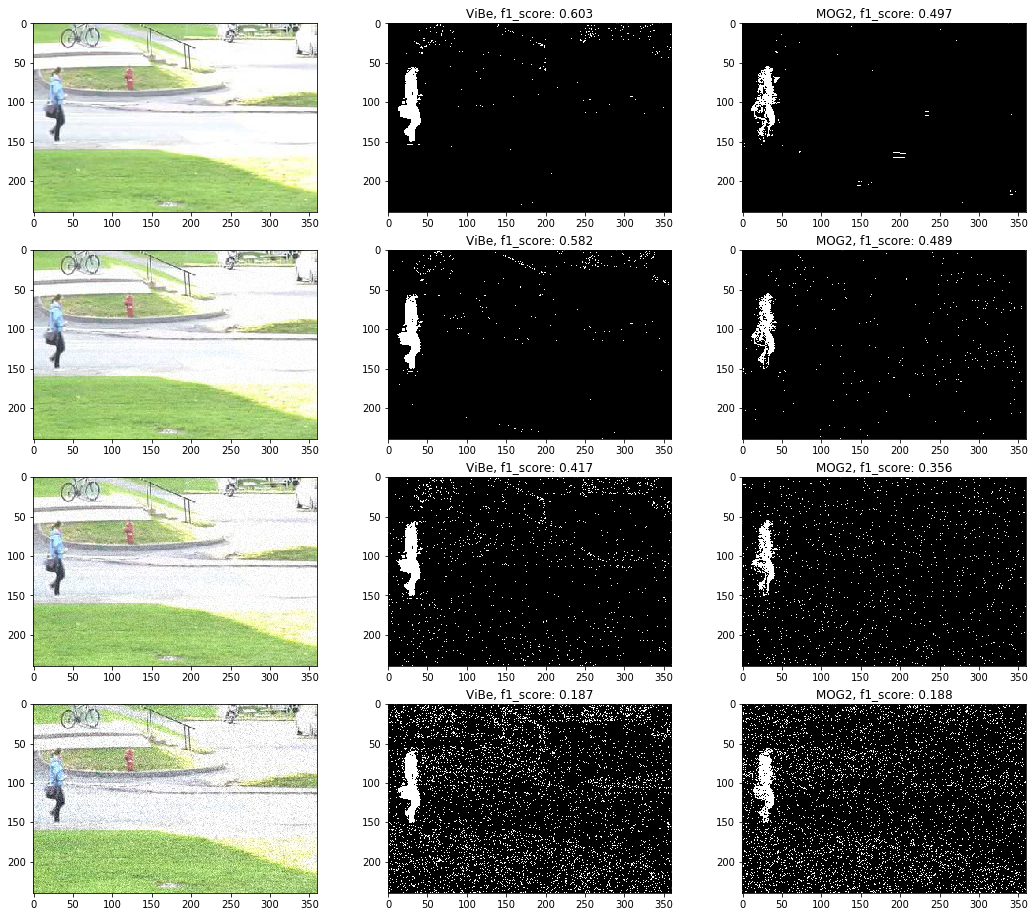

In [111]:
sigmas = [0, 5, 10, 20]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    frame, mog2_mask, gt = get_mog2_result(sigma)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("ViBe, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    
    axs[i][2].imshow(mog2_mask, cmap='gray')
    axs[i][2].set_title("MOG2, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(mog2_mask, gt))))

**Выводы:**

Оба алгоритма сильно теряют в качестве при зашумлении, тем не менее ViBe показывает лучшие результаты

**8. (1 балл)**

Предложите метод борьбы с шумом на карте "фон-объект" и проанализируйте его эффективность. Сравнивайте результаты по какой-нибудь метрики качества, например $f_1{\text -}score$.

*Замечание:*

Можно использовать любые функции обработки изображений из библиотек `opencv` и `skimage`.

In [115]:
from skimage.restoration import denoise_wavelet

In [124]:
def postprocess(mask):
    """
    Postprocessing foreground mask
    """
    denoised_mask = denoise_wavelet(mask)
    return np.round(denoised_mask)

/usr/local/lib/python3.6/site-packages/skimage/restoration/_denoise.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return pywt.waverecn(denoised_coeffs, wavelet)[original_extent]


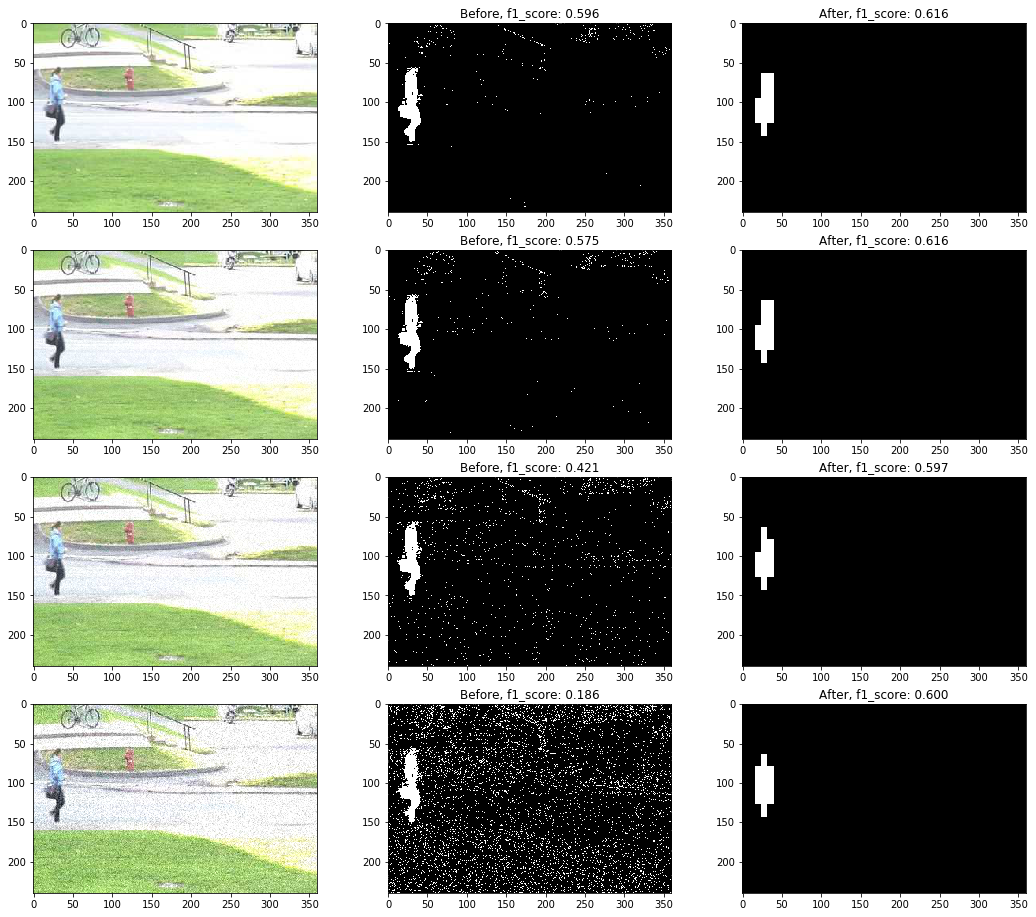

In [125]:
sigmas = [0, 5, 10, 20]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    process_mask = postprocess(vibe_mask)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("Before, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    
    axs[i][2].imshow(process_mask, cmap='gray')
    axs[i][2].set_title("After, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(process_mask, gt))))

**Выводы:**

Подавление шумов позволяет не терять качество, но при этом объекты теряют четкие границы 